In [1]:
!pip install matplotlib
!pip install scikit-image
!pip install torch torchvision torchaudio
!pip install scikit-learn
!pip3 install git+https://github.com/facebookresearch/segment-anything.git
!pip install opencv-python
!apt update && apt install -y libgl1
!apt install git-lfs
!pip install requests
!pip install peft
!pip install pandas


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 55.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.2/326.2 kB 111.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 65.8 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 99.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 67.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 58.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 kB 61.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2gray
from PIL import Image

class kart_frame:
    def __init__ (self, name, road):
        self.name = name
        self.road = road
        self.base_path = "dense_data/{}/{}/{}_{}.png"
        self.masks = []
        self.images = []
        self.image = None
        self.row = None  # Initialize row to None
        self.row1 = {}
        self.load_masks()
    
    def get_image_path(self):
        """
        Returns the path to the image file for the kart frame.
        """
        base_path = "dense_data/{}/{}/{}.png"
        return base_path.format(self.road, "frame", self.name)
            
    def load_masks(self):
        frames = ["frame","kart","nitro","background","bomb","pickup","projectile","track","combined"]
        for frame in frames:
            mask = {}
            image_prefix = "mask"
            
            if(frame == "frame"):
                image_prefix = "frame"
            elif(frame == "combined"):
                image_prefix="mask_combined"

            image_path = self.base_path.format(self.road, frame, image_prefix, self.name)

            mask[frame] = image_path
            if not os.path.exists(image_path):
                #print(f"Mask not found: {image_path}")
                mask["hasMask"] = False
                mask["image"] = Image.new("RGB", (256, 256), color=(0, 100, 0)) 
            else:
                mask["hasMask"] = True
                mask["image"] = Image.open(image_path)

            mask["name"] = self.name
            mask["road"] = self.road
            mask["mask_name"] = f"{self.name}_{frame}"
            mask["image_prefix"] = image_prefix
            mask["image_path"] = image_path
            mask["frame"] = frame
            self.image = mask["image"]  # Store the last loaded image as the main image
            
            self.masks.append(mask)

        self.row = self.get_frame_as_row()
        self.row1["has_kart_frame"] = [item["hasMask"] for item in self.masks if item["frame"] == "kart"][0]


    def print_info(self):
        print(f"Name: {self.name}")
        print(f"Road: {self.road}")
        print("Masks:")
        for mask in self.masks:
            print(f"  - {mask['mask_name']} (Path: {mask['image_path']}, Has Mask: {mask['hasMask']})")

    def print_masks(self):
        fig, ax = plt.subplots(3,3,figsize=(10, 10))

        index = 0
        for i in range(3):
            for j in range(3):        
                img = self.masks[index]["image"]#images[index]
                name = self.masks[index]["mask_name"]#names[index]
                ax[i][j].imshow(img, cmap="gray")
                ax[i][j].axis('off')
                ax[i][j].set_title(name)
                index += 1
                
        plt.tight_layout()
        plt.show()

    def ensure_grayscale(self, img):
        """
        Devuelve una versión en escala de grises de una imagen.
        Si ya está en escala de grises, la devuelve tal cual.
        """
        img_array = np.array(img)

        if len(img_array.shape) == 2:
            return img_array  # Ya es gris
        elif len(img_array.shape) == 3 and img_array.shape[2] == 3:
            return rgb2gray(img_array)
        else:
            raise ValueError(f"Formato de imagen no soportado: {img_array.shape}")

    def get_similar_mask(self, mask_to_compare, num_classes=2):
        """
        Compara una máscara con una lista de máscaras usando Mean IoU
        y retorna la más similar.
        
        Args:
            mask_to_compare: máscara a comparar (imagen binaria o multiclase)
            num_classes: número de clases distintas en las máscaras

        Returns:
            similarity (float): Mean IoU.
            similar_mask: máscara más parecida.
        """
        frames_to_compare = ["kart","nitro","background","bomb","pickup","projectile","track"]

        best_similarity = 0.0
        similar_mask = None

        gray_mask_to_compare = self.ensure_grayscale(mask_to_compare)
        mask1 = (gray_mask_to_compare > 0.5).astype(np.uint8)

        for mask in self.masks:
            print(mask)
            if mask["frame"] not in frames_to_compare:
                continue
            if not mask.get("hasMask", False):
                continue
            print("#" * 20)
            print(mask["frame"])
            local_gray_mask = self.ensure_grayscale(mask["image"])
            mask2 = (local_gray_mask > 0.5).astype(np.uint8)

            if mask1.shape != mask2.shape:
                continue

            current_iou = self.compute_mean_iou(mask1, mask2, num_classes=num_classes)

            if current_iou > best_similarity:
                best_similarity = current_iou
                similar_mask = mask["image"]

        return best_similarity, similar_mask, mask["frame"]
    
    def compute_mean_iou(self, mask1, mask2, num_classes=2):
        """
        Compute mean Intersection over Union between two masks.
        Both masks must be NumPy arrays with the same shape.
        """
        mask1 = mask1.flatten()
        mask2 = mask2.flatten()
        ious = []

        for cls in range(num_classes):
            m1 = mask1 == cls
            m2 = mask2 == cls
            intersection = np.logical_and(m1, m2).sum()
            union = np.logical_or(m1, m2).sum()
            if union == 0:
                continue  # ignore classes not present
            ious.append(intersection / union)

        return np.mean(ious) if ious else 0.0      
    
    def get_frame_as_row(self):
        """
        Returns the row of the kart frame.
        """

        if self.image is None:
            try:
                self.image = Image.open(self.get_image_path()).convert("RGB")
            except FileNotFoundError:
                print(f"[WARN] Imagen no encontrada: {self.get_image_path()}")
                self.image = Image.new("RGB", (256, 256), color=(255, 0, 0)) 
        row = {}

        row["path"] = self.get_image_path()
        row["name"] = self.name
        row["road"] = self.road
        row["image"] = self.image
        row["has_kart_frame"] = any(item["frame"] == "kart" and item["hasMask"] for item in self.masks)
        row["has_nitro_frame"] = any(item["frame"] == "nitro" and item["hasMask"] for item in self.masks)
        row["has_background_frame"] = any(item["frame"] == "background" and item["hasMask"] for item in self.masks)
        row["has_bomb_frame"] = any(item["frame"] == "bomb" and item["hasMask"] for item in self.masks)
        row["has_pickup_frame"] = any(item["frame"] == "pickup" and item["hasMask"] for item in self.masks)
        row["has_projectile_frame"] = any(item["frame"] == "projectile" and item["hasMask"] for item in self.masks)
        row["has_track_frame"] = any(item["frame"] == "track" and item["hasMask"] for item in self.masks)

        row["has_predicted_frame"] = False
        row["has_predicted_nitro"] = False
        row["has_predicted_background"] = False
        row["has_predicted_bomb"] = False
        row["has_predicted_pickup"] = False
        row["has_predicted_projectile"] = False
        row["has_predicted_track"] = False

        return row


In [3]:
import os
import torch
import numpy as np
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2

class SuperTuxKartDataset(Dataset):
    def __init__(self, root_dir, tracks, transform_img=None, transform_mask=None):
        if isinstance(tracks, str):
            tracks = [tracks]

        self.image_paths = []
        self.mask_paths = []

        for track in tracks:
            image_dir = os.path.join(root_dir, track, "frame")
            mask_dir = os.path.join(root_dir, track, "combined")

            image_files = sorted([
                f for f in os.listdir(image_dir) if f.endswith(".png")
            ])
            mask_files = sorted([
                f for f in os.listdir(mask_dir) if f.endswith(".png")
            ])

            assert len(image_files) == len(mask_files), f"Track '{track}' tiene distinto número de imágenes y máscaras."
            
            for img_file, mask_file in zip(image_files, mask_files):
                self.image_paths.append(os.path.join(image_dir, img_file))
                self.mask_paths.append(os.path.join(mask_dir, mask_file))

        self.transform_img = transform_img
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path)

        if self.transform_img:
            image = self.transform_img(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)
        else:
            mask = torch.from_numpy(np.array(mask)).long()

        return image, mask
    
    def get_frame_object(self, idx):
        """
        Returns the kart_frame object for the given index.
        """
        if idx < 0 or idx >= len(self.image_paths):
            raise IndexError("Index out of range")

        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        name = os.path.splitext(os.path.basename(img_path))[0]
        road = os.path.basename(os.path.dirname(os.path.dirname(img_path)))

        frame = kart_frame(name, road)
        frame.image = Image.open(img_path).convert('RGB')
        
        frame.load_masks()
        
        return frame
    
    def get_frame_collection(self):
        """
        Returns a list of kart_frame objects for the dataset.
        """
        frames = []
        for idx in range(len(self)):
            frames.append(self.get_frame_object(idx))
        return frames
    
    def to_dataframe(self):
        """
        Transforma el dataset en un DataFrame donde cada fila es una instancia del objeto `kart_frame`.
        """
        rows = []

        for idx in range(len(self)):
            name = os.path.splitext(os.path.basename(self.image_paths[idx]))[0]
            road = os.path.basename(os.path.dirname(os.path.dirname(self.image_paths[idx])))
            frame = kart_frame(name, road)
            row = frame.get_frame_as_row()
            rows.append(row)

        return pd.DataFrame(rows)

In [4]:
from collections import Counter

def get_class_name(index):
    class_names = [
        "Background", "Track", "Kart", "Pickup", "Nitro", "Bomb", "Projectile"
    ]
    if 0 <= index < len(class_names):
        return class_names[index]
    else:
        return "Unknown Class"

def contar_clases_dataset(dataset):
    contador = Counter()

    for _, mask in dataset:
        if mask.ndim == 3 and mask.shape[0] == 1:
            mask = mask.squeeze(0)
        valores, conteos = torch.unique(mask, return_counts=True)
        for val, count in zip(valores.tolist(), conteos.tolist()):
            contador[val] += count

    print("Distribución de clases en el dataset:")
    for clase, cantidad in sorted(contador.items()):
        print(f"Clase { get_class_name(clase)}: {cantidad} píxeles")

    return contador

def tiene_clase_rara(mask):
  clases_raras = {3, 4, 5, 6}
  return any(c in clases_raras for c in torch.unique(mask).tolist())

def get_rare_sample(dataset):
  rare_samples = [dataset[i] for i in range(len(dataset)) if tiene_clase_rara(dataset[i][1])]
  return rare_samples

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re

tracks = ["olivermath", "abyss", "gran_paradiso_island", "lighthouse","volcano_island","hacienda"]

frames_collection = []

for track in tracks:
    frame_dir = os.path.join("dense_data", track,"frame")
    if not os.path.exists(frame_dir):
        print(f"Directorio no encontrado: {frame_dir}")
        continue
    frame_files = sorted([f for f in os.listdir(frame_dir) if f.endswith(".png")])

    for filename in frame_files:
        match = re.search(r'frame_(\d+)\.png', filename)

        if match:
            number = match.group(1)
            kframe = kart_frame(number, track)

            frames_collection.append(kframe.row)

df = pd.DataFrame(frames_collection)

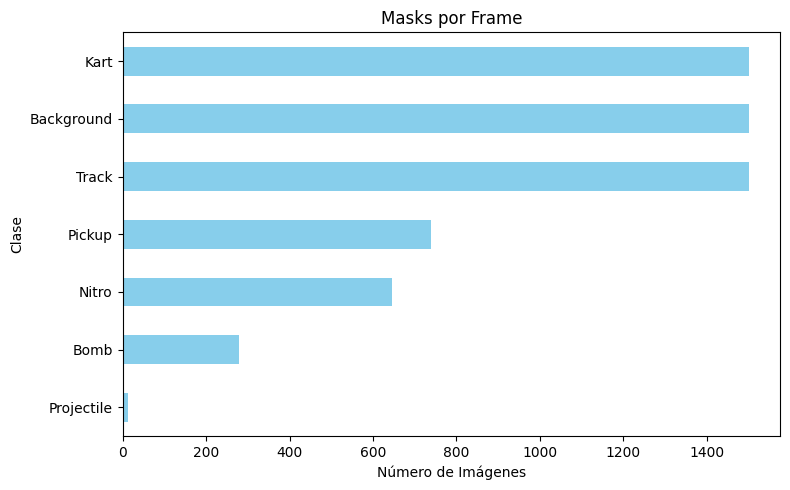

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import os

df_predicted = df[[col for col in df.columns if '_predicted_' not in col]]

df_predicted = df_predicted.rename(columns={
    'has_kart_frame': 'Kart',
    'has_background_frame': 'Background',
    'has_nitro_frame': 'Nitro',
    'has_bomb_frame': 'Bomb',
    'has_pickup_frame': 'Pickup',
    'has_projectile_frame': 'Projectile',
    'has_track_frame': 'Track',
})

bool_columns = df_predicted.select_dtypes(include='bool').columns
conteo_true = df_predicted[bool_columns].sum().sort_values(ascending=False)

import matplotlib.pyplot as plt

conteo_true.plot(kind="barh", figsize=(8, 5), color="skyblue")
plt.xlabel("Número de Imágenes")
plt.ylabel("Clase")
plt.title("Masks por Frame")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Imagen: torch.Size([3, 224, 224]), Máscara: torch.Size([1, 224, 224]), Clases: tensor([0, 1, 2, 4])


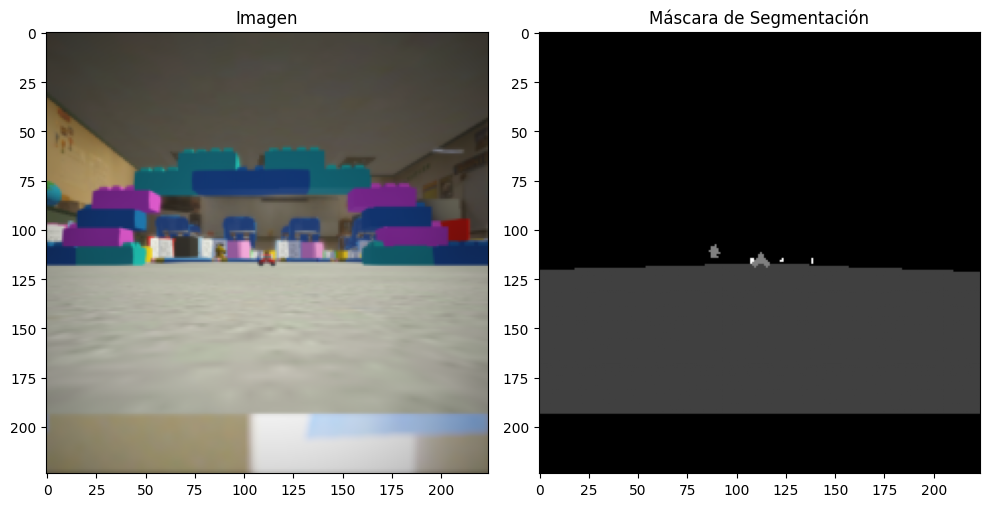

In [7]:
from torchvision.transforms import v2
from torch.utils.data import DataLoader, random_split
from torch.utils.data import ConcatDataset

CMAP="gray"

transform_img_old = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.CenterCrop(400),
    v2.Resize((224, 224))
])

transform_mask = v2.Compose([
    v2.ToImage(),
    v2.CenterCrop(400),
    v2.Resize((224, 224), interpolation=Image.NEAREST),
    v2.ToDtype(torch.int64)
])

tracks = ["olivermath", "abyss", "gran_paradiso_island", "lighthouse","volcano_island","hacienda"]

dataset = SuperTuxKartDataset(
    root_dir="dense_data",
    tracks=tracks,
    transform_img=transform_img_old,
    transform_mask=transform_mask
)

rare_samples = get_rare_sample(dataset)
augmented_dataset = ConcatDataset([dataset] + [rare_samples] * 10)

train_size = int(0.8 * len(augmented_dataset))
test_size = len(augmented_dataset) - train_size
train_dataset, test_dataset = random_split(augmented_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=180, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=180, shuffle=False)

img, mask = dataset[0]

print(f"Imagen: {img.shape}, Máscara: {mask.shape}, Clases: {torch.unique(mask)}")

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img.permute(1, 2, 0).cpu().numpy())
plt.title("Imagen")

plt.subplot(1, 2, 2)
plt.imshow(mask.squeeze().cpu().numpy(), cmap=CMAP)
plt.title("Máscara de Segmentación")

plt.tight_layout()
plt.show()

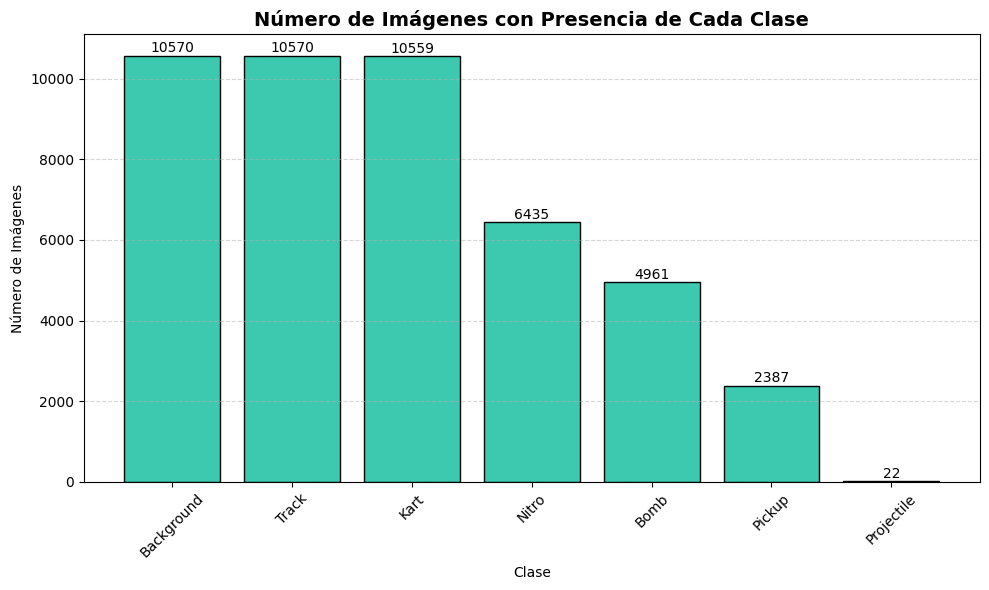

In [8]:
from collections import Counter
import torch
from torch.utils.data import Dataset

def contar_presencia_por_imagen(dataset, num_clases=7):
    contador = Counter()

    for i in range(len(dataset)):
        _, mask = dataset[i]
        clases_presentes = torch.unique(mask).tolist()
        for clase in clases_presentes:
            contador[clase] += 1

    return contador 

class_names = {
    0: 'Background',
    1: 'Track',
    2: 'Kart',
    3: 'Nitro',
    4: 'Bomb',
    5: 'Pickup',
    6: 'Projectile',
    
}

def plot_presencia_imagenes(contador):
    clases = sorted(contador.keys())
    nombres = [class_names[c] for c in clases]
    conteos = [contador[c] for c in clases]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(nombres, conteos, color="#3DC9B0", edgecolor="black")

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 5,
                 str(height), ha='center', va='bottom', fontsize=10)

    plt.title("Número de Imágenes con Presencia de Cada Clase", fontsize=14, weight='bold')
    plt.xlabel("Clase")
    plt.ylabel("Número de Imágenes")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


contador = contar_presencia_por_imagen(augmented_dataset)
plot_presencia_imagenes(contador)


In [9]:
!pip install pynvml

ValueError: filedescriptor out of range in select()

In [10]:
import torch
import pynvml

def get_best_cuda_device():
    if not torch.cuda.is_available():
        print("CUDA no está disponible. Usando CPU.")
        return torch.device("cpu")
    
    pynvml.nvmlInit()
    best_gpu = 0
    max_free_mem = 0

    for i in range(torch.cuda.device_count()):
        handle = pynvml.nvmlDeviceGetHandleByIndex(i)
        mem_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
        free_mem = mem_info.free
        print(f"GPU {i} - Memoria libre: {free_mem / 1024**2:.2f} MiB")
        
        if free_mem > max_free_mem:
            best_gpu = i
            max_free_mem = free_mem

    pynvml.nvmlShutdown()
    print(f"Seleccionando GPU {best_gpu} con más memoria libre.")
    return torch.device(f"cuda:{best_gpu}")

In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

ValueError: filedescriptor out of range in select()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision.transforms import v2
from PIL import Image
import math
import time
from segment_anything import sam_model_registry

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cuda:1" if torch.cuda.device_count() > 1 else "cuda")

device = get_best_cuda_device()
print("Usando device:", device)

print("Usando GPU:", torch.cuda.current_device())
print("Nombre:", torch.cuda.get_device_name(torch.cuda.current_device()))
# --- Configuración ---
sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"
num_classes = 7
batch_size = 10
epochs = 1

# --- Cargar modelo SAM ---
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(device)
sam.eval()
image_encoder = sam.image_encoder

# --- LoRA ---
class LoRALinear(nn.Module):
    def __init__(self, original_linear, r=8, alpha=16):
        super().__init__()
        self.original = original_linear
        self.r = r
        self.alpha = alpha
        in_features = original_linear.in_features
        out_features = original_linear.out_features

        self.lora_down = nn.Linear(in_features, r, bias=False)
        self.lora_up = nn.Linear(r, out_features, bias=False)
        self.scaling = alpha / r

        nn.init.kaiming_uniform_(self.lora_down.weight, a=math.sqrt(5))
        nn.init.zeros_(self.lora_up.weight)

    def forward(self, x):
        return self.original(x) + self.scaling * self.lora_up(self.lora_down(x))

def inject_lora_into_sam(sam, r=8, alpha=16, target_blocks=[8,9,10,11]):
    for name, module in sam.image_encoder.named_modules():
        for block_idx in target_blocks:
            if name == f"blocks.{block_idx}.attn" and hasattr(module, 'qkv') and isinstance(module.qkv, nn.Linear):
                print(f"Inyectando LoRA en: {name}.qkv")
                module.qkv = LoRALinear(module.qkv, r=r, alpha=alpha).to(device)

inject_lora_into_sam(sam)

# --- Segmentación con SAM + LoRA ---
class SAMLoRASegmentation(nn.Module):
    def __init__(self, encoder, num_classes):
        super().__init__()
        self.encoder = encoder
        self.decoder = EdgeEnhancedDecoder(in_channels=256, num_classes=num_classes)

    def forward(self, x):
        embeddings = self.encoder(x)
        return self.decoder(embeddings)
    
class EdgeEnhancedDecoder(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        # Upsample progresivo + convoluciones profundas
        self.up1 = nn.Sequential(
            nn.Conv2d(in_channels, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        )
        self.up2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        )
        self.up3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, num_classes, kernel_size=1)
        )

        # Cabeza auxiliar para detección de bordes (1 canal)
        self.edge_head = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=1)  # mapa de bordes
        )

    def forward(self, x):
        x = self.up1(x)         # -> [B, 256, H/2, W/2]
        x = self.up2(x)         # -> [B, 128, H, W]
        edge_map = self.edge_head(x)  # para pérdidas auxiliares si se desea
        x = self.up3(x)         # -> [B, num_classes, H, W]
        return x, edge_map
    
model = SAMLoRASegmentation(sam.image_encoder, num_classes).to(device)

# --- Normalización ImagenNet ---
mean = torch.tensor([123.675, 116.28, 103.53], device=device) / 255.0
std = torch.tensor([58.395, 57.12, 57.375], device=device) / 255.0

transform_img_old = v2.Compose([
    v2.ToImage(),
    v2.Resize((1024, 1024)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean.tolist(), std=std.tolist())
])

transform_img = v2.Compose([
    v2.ToImage(),
    v2.Resize((1024, 1024)),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(degrees=15),
    v2.ColorJitter(brightness=0.2, contrast=0.2),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean.tolist(), std=std.tolist())
])

transform_mask = v2.Compose([
    v2.ToImage(),
    v2.Resize((256, 256), interpolation=Image.NEAREST),
    v2.ToDtype(torch.int64)
])

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        logits = torch.softmax(logits, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=logits.shape[1]).permute(0, 3, 1, 2).float()
        
        intersection = (logits * targets_one_hot).sum(dim=(2, 3))
        union = logits.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3))
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()
    
# --- Dataset ---
tracks = ["olivermath", "abyss", "gran_paradiso_island", "lighthouse", "volcano_island", "hacienda"]
dataset = SuperTuxKartDataset(root_dir="dense_data", tracks=tracks,
                              transform_img=transform_img, transform_mask=transform_mask)

rare_samples = get_rare_sample(dataset)
augmented_dataset = ConcatDataset([dataset] + [rare_samples] * 50)

train_size = int(0.8 * len(augmented_dataset))
train_dataset, test_dataset = random_split(augmented_dataset, [train_size, len(augmented_dataset) - train_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# --- Solo entrenar LoRA y decoder ---
for name, param in model.named_parameters():
    if "lora" not in name.lower() and "decoder" not in name:
        param.requires_grad = False

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

def extract_edges_from_mask(masks):
    # Espera máscaras de tamaño (B, 1, H, W) o (B, H, W)
    from torchvision import transforms
    import torch.nn.functional as F

    if masks.ndim == 4:
        masks = masks.squeeze(1)
    
    # Aplica filtro de borde Sobel como convolución
    sobel_x = torch.tensor([[1, 0, -1],
                            [2, 0, -2],
                            [1, 0, -1]], dtype=torch.float32, device=masks.device).unsqueeze(0).unsqueeze(0) / 8.0
    sobel_y = torch.tensor([[1, 2, 1],
                            [0, 0, 0],
                            [-1, -2, -1]], dtype=torch.float32, device=masks.device).unsqueeze(0).unsqueeze(0) / 8.0

    edge_x = F.conv2d(masks.unsqueeze(1).float(), sobel_x, padding=1)
    edge_y = F.conv2d(masks.unsqueeze(1).float(), sobel_y, padding=1)
    edge_mag = torch.sqrt(edge_x ** 2 + edge_y ** 2)
    edge_binary = (edge_mag > 0.1).float()
    return edge_binary

# --- Entrenamiento ---
for epoch in range(epochs):
    print("----" * 20)
    print(f"Epoch {epoch + 1}/{epochs}")
    model.train()
    total_loss = 0
    counting = 0
    start_time = time.perf_counter()

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
            preds, edge_map = model(images)

            # Predicción de clase
            dice_loss = DiceLoss()
            seg_loss = 0.5 * F.cross_entropy(preds, masks.squeeze(1)) + 0.5 * dice_loss(preds, masks.squeeze(1))

            # Extraer bordes de las máscaras reales
            edge_targets = extract_edges_from_mask(masks)
            edge_loss = F.binary_cross_entropy_with_logits(edge_map, edge_targets)

            # Combinar pérdidas
            loss = seg_loss + 0.2 * edge_loss

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        counting += 1

        if counting % 100 == 0:
            elapsed = time.perf_counter() - start_time
            print(f"Batch: {counting}/{len(train_loader)} | Loss: {loss.item():.4f} | Time: {elapsed:.2f}s")

    print(f"[{epoch + 1}/{epochs}] Total Loss: {total_loss:.4f}")

torch.save(model.state_dict(), "sam_lora_segmentation.pth")
print("Modelo guardado en 'sam_lora_segmentation.pth'")

GPU 0 - Memoria libre: 55223.81 MiB
GPU 1 - Memoria libre: 42163.62 MiB
Seleccionando GPU 0 con más memoria libre.
Usando device: cuda:0
Usando GPU: 0
Nombre: NVIDIA A100 80GB PCIe
Inyectando LoRA en: blocks.8.attn.qkv
Inyectando LoRA en: blocks.9.attn.qkv
Inyectando LoRA en: blocks.10.attn.qkv
Inyectando LoRA en: blocks.11.attn.qkv


/tmp/ipykernel_8984/133645619.py:169: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))
/tmp/ipykernel_8984/133645619.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):


--------------------------------------------------------------------------------
Epoch 1/1
Batch: 100/3800 | Loss: 0.5822 | Time: 57.40s
Batch: 200/3800 | Loss: 0.3461 | Time: 115.27s
Batch: 300/3800 | Loss: 0.3107 | Time: 173.51s
Batch: 400/3800 | Loss: 0.3387 | Time: 231.66s
Batch: 500/3800 | Loss: 0.3344 | Time: 289.16s
Batch: 600/3800 | Loss: 0.2571 | Time: 346.50s


In [ ]:
import os
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score

os.makedirs("outputs/predictions", exist_ok=True)

model.eval()
test_loss = 0
all_preds = []
all_targets = []

with torch.no_grad():
    counter = 0
    for batch_idx, (images, masks) in enumerate(test_loader):
        images, masks = images.to(device), masks.to(device)

        if counter % 10 == 0:
            print(f"Processing {counter} of {len(test_loader)}")

        with torch.amp.autocast(device_type=device.type, enabled=(device.type == "cuda")):
            preds = model(images)
            loss = F.cross_entropy(preds, masks.squeeze(1))
            test_loss += loss.item()

        pred_classes = torch.argmax(preds, dim=1)  # [B, H, W]

        all_preds.extend(pred_classes.view(-1).cpu().numpy())
        all_targets.extend(masks.view(-1).cpu().numpy())

        for i in range(images.size(0)):
            pred_mask = pred_classes[i].cpu().numpy().astype(np.uint8)
            gt_mask = masks[i].squeeze().cpu().numpy().astype(np.uint8)

            color_pred = cv2.applyColorMap((pred_mask * 30).astype(np.uint8), cv2.COLORMAP_JET)
            color_gt = cv2.applyColorMap((gt_mask * 30).astype(np.uint8), cv2.COLORMAP_JET)

            cv2.imwrite(f"outputs/predictions/pred_{counter}_{i}.png", color_pred)
            cv2.imwrite(f"outputs/predictions/gt_{counter}_{i}.png", color_gt)

        counter += 1

avg_test_loss = test_loss / len(test_loader)
mean_iou = jaccard_score(all_targets, all_preds, average="macro", zero_division=0)

print(f"Validation Loss: {avg_test_loss:.4f} | Mean IoU: {mean_iou:.4f}")

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(color_gt)
axs[0].set_title("Ground Truth")
axs[0].axis("off")

axs[1].imshow(color_pred)
axs[1].set_title("Prediction")
axs[1].axis("off")

plt.tight_layout()
plt.show()